In [1]:
from insert_gals import add_to_cube, load_cube, smooth_cube, regrid_cube, insert_gal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import register_cmap
import astropy.units as u
from astropy.visualization import ImageNormalize, ZScaleInterval

In [2]:

# Get ds9 map
ds9aips0 = {'red': lambda v : np.select([v < 1/9., v < 2/9., v < 3/9., v < 4/9., v < 5/9.,
                                        v < 6/9., v < 7/9., v < 8/9., v <= 1],
                                        [0.196, 0.475, 0, 0.373, 0, 0, 1, 1, 1]), 
            'green': lambda v : np.select([v < 1/9., v < 2/9., v < 3/9., v < 4/9., v < 5/9.,
                                        v < 6/9., v < 7/9., v < 8/9., v <= 1],
                                        [0.196, 0, 0, 0.655, 0.596, 0.965, 1, 0.694, 0]),
            'blue': lambda v : np.select([v < 1/9., v < 2/9., v < 3/9., v < 4/9., v < 5/9.,
                                        v < 6/9., v < 7/9., v < 8/9., v <= 1],
                                        [0.196, 0.608, 0.785, 0.925, 0, 0, 0, 0, 0])}
register_cmap('ds9aips0', data=ds9aips0)

def plot_slice(cube_data, cube_wcs, slice_i):
    fig = plt.figure()
    norm = ImageNormalize(cube_data[slice_i], interval=ZScaleInterval())
    axis = fig.add_subplot(projection=cube_wcs, slices=('y', 'x', slice_i))
    image = axis.imshow(cube_data[slice_i], origin='lower', norm=norm, cmap='ds9aips0')
    cbar = plt.colorbar(image)
    cbar.set_label('Frequency (Hz)', size=16)
    plt.xlabel('Right Ascension (J2000)', fontsize=16)
    plt.ylabel('Declination (J2000)', fontsize=16)
    plt.show()

<ipython-input-2-09b7686fc718>:11: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cmap=LinearSegmentedColormap(name, data, lut))
  register_cmap('ds9aips0', data=ds9aips0)


Load noise cube

In [3]:
noise_file = 'data/mosaics/1353mosF.derip.fits'

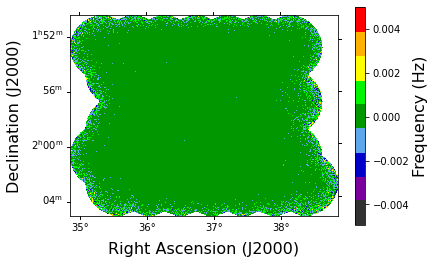

In [4]:
noise_cube = load_cube(noise_file)
noise_data = noise_cube.unmasked_data[:, :, :].value
empty_cube = np.zeros(noise_cube.shape)
plot_slice(noise_data, noise_cube.wcs, 471)

1. Load galaxy

In [5]:
gal_file = 'data/mock_gals/model1000.fits'
orig_d = 50*u.Mpc
fwhm1 = 15*u.arcsec
fwhm2 = 27*u.arcsec
h_0 = 70*u.km/(u.Mpc*u.s)

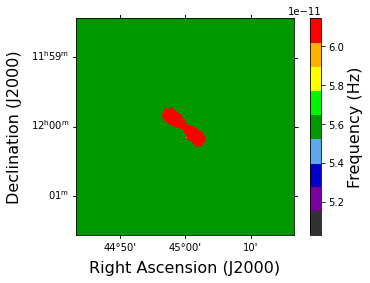

In [6]:
gal_cube = load_cube(gal_file)
gal_data = gal_cube.unmasked_data[:, :, :].value*5e-3
plot_slice(gal_data, gal_cube.wcs, 100)

2. Spatially smooth the galaxies (because it is independent of the distance) using guassians with:

\begin{align}
\sigma&=\frac{FWHM=15arcsec}{2\sqrt{2ln2}}\\
&= 6.3699135arcsec
\end{align}

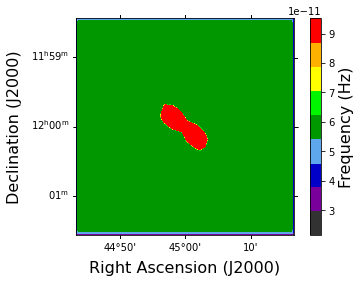

In [7]:
smoothed_gal = smooth_cube(gal_cube, fwhm1, fwhm2)
plot_slice(smoothed_gal, gal_cube.wcs, 100)

3. Regrid the galaxy cube:

\begin{align}
\nu_{obs} &= \frac{\nu_{rest}}{1+z}\\
&=\frac{\nu_{rest}}{1+\frac{dH_0}{c}}
\end{align}

Note, the closer the source, the smaller the distance, the larger the observed frequency. Therefore, we must pick a random frequency channel to insert the galaxy into, below the maximum frequency so that it is above a minimum distance. The galaxy cubes are currently at a distance 50Mpc. Then calculate what the ratio of the new insertion distance to the old distance and use this and the pixel seperation ratios to find the new dimensions to regrid to.

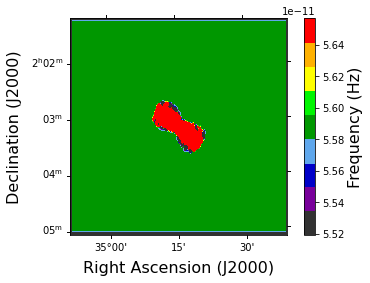

In [8]:
z_pos, resampled = regrid_cube(gal_cube, noise_cube, smoothed_gal, orig_d, h_0)
plot_slice(resampled, noise_cube.wcs, int(resampled.shape[0]/2))

5. Insert galaxy

In [9]:
success = insert_gal(resampled, noise_data, empty_cube, z_pos, verbose=True)

627 484


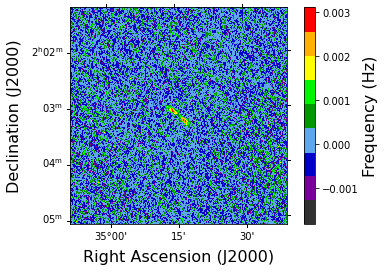

In [10]:
plot_slice(noise_data[:, 627:627+resampled.shape[1], 484:484+resampled.shape[2]], noise_cube.wcs, int(z_pos)+int(resampled.shape[0]/2))